# HSIC

**HSIC（Hilbert-Schmidt Independence Criterion, [Gretton, et al. 2005](https://www.gatsby.ucl.ac.uk/~gretton/papers/GreBouSmoSch05.pdf)）** は再生核ヒルベルト空間（RKHS）のカーネルを用いて高次元・非線形依存を検出する手法。


### 定義式

与えられたRBFカーネル $k(x,x')$, $l(y,y')$ を用いて

$$
\mathrm{HSIC}(X,Y)
=
\frac{1}{(n-1)^2}
\mathrm{tr}( KHLH )
$$

ここで  
- $K_{ij} = k(x_i, x_j)$
- $L_{ij} = l(y_i, y_j)$
- $H = I_n - \frac{1}{n}\mathbf{1}\mathbf{1}^\top$（中心化行列）

RBFカーネル

$$
k(x, x^{\prime})=\exp \left(-\frac{\left\|x-x^{\prime}\right\|^2}{2 \sigma^2}\right)
$$

はスケール$\sigma$がハイパーパラメータであり、スケールの設定次第でHSICの値は変わる。

### 特徴
- カーネル次第で非常に多様な非線形関係を検出  
- 多変量にも自然に拡張できる  
- ハイパーパラメータに依存


## 実装


In [63]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

def hsic(X, Y, sigma_x=None, sigma_y=None):
    """
    X: shape (n, d1)
    Y: shape (n, d2)
    """
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    if len(Y.shape) == 1:
        Y = Y.reshape(-1, 1)

    # set sigma by median of distance
    sigma_x = sigma_x or median_sigma(X)
    sigma_y = sigma_y or median_sigma(Y)
        
    n = X.shape[0]
    K = rbf_kernel(X, X, gamma=1/(2*sigma_x**2))
    L = rbf_kernel(Y, Y, gamma=1/(2*sigma_y**2))
    H = np.eye(n) - np.ones((n, n)) / n
    return (1 / (n - 1)**2) * np.trace(K @ H @ L @ H)

def median_sigma(X):
    # set sigma by median of distance
    dists = np.sqrt(((X[:, None, :] - X[None, :, :])**2).sum(axis=2))
    return np.median(dists)

# サンプルデータ
np.random.seed(0)
x = np.linspace(0, 10, 200).reshape(-1, 1)
y = np.sin(x) + 0.3*np.random.randn(200, 1)

# HSIC の実行
value = hsic(x, y)
print("HSIC:", value)

HSIC: 0.011830828031023408


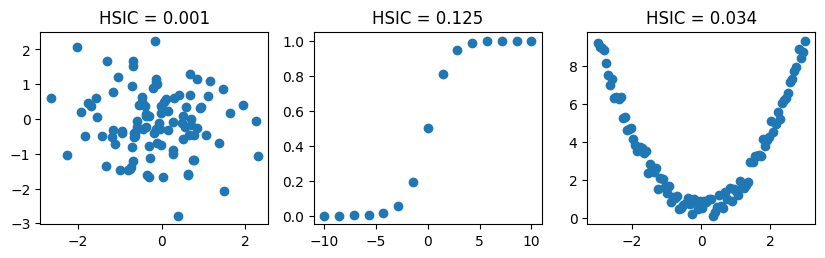

In [64]:
import numpy as np
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=[10, 2.5], ncols=3)

true_r = 0
mu = np.array([0.0, 0.0])
Sigma = np.array([[1.0, true_r], [true_r, 1.0]])
samples = np.random.multivariate_normal(mu, Sigma, size=100)
x = samples[:, 0]
y = samples[:, 1]
axes[0].scatter(x, y)
axes[0].set_title(f"HSIC = {hsic(x, y):.3f}")

x = np.linspace(-10, 10, 15)
y = 1 / (1 + np.exp(-x))
axes[1].scatter(x, y)
axes[1].set_title(f"HSIC = {hsic(x, y):.3f}")

x = np.linspace(-3, 3, 100)
y = x**2 + np.random.random(len(x))
axes[2].scatter(x, y)
axes[2].set_title(f"HSIC = {hsic(x, y):.3f}")

%matplotlib inline

## HSICを使った独立性検定

実装：[amber0309/HSIC: Python code of Hilbert-Schmidt Independence Criterion](https://github.com/amber0309/HSIC)

## HSICの損失関数としての利用

[Mooij et al. (2009)](https://doi.org/10.1145/1553374.1553470) はHSICを使って残差と特徴量の統計的依存性を最小化する方法で学習する回帰モデルを因果推論に使う方法を提案した。

[Greenfeld et al. (2019)](https://arxiv.org/abs/1910.00270) は機械学習の文脈でHSICを損失関数として活用

$$
\min_{h\in \mathcal{H}}
HSIC(X, \underbrace{ Y-h(X)}_{\text{residual}} )
$$

ここで $\mathcal{H}$ はhypothesis class



## 参考

- [21世紀の手法対決 (MIC vs HSIC) | PDF](https://www.slideshare.net/slideshow/tokyo-r-lt-25759212/25759212)
- [Mooij et al. (2009). Regression by dependence minimization and its application to causal inference in additive noise models.](https://doi.org/10.1145/1553374.1553470)
- [Gretton, A., Bousquet, O., Smola, A., & Schölkopf, B. (2005, October). Measuring statistical dependence with Hilbert-Schmidt norms. In International conference on algorithmic learning theory (pp. 63-77). Berlin, Heidelberg: Springer Berlin Heidelberg.](https://www.gatsby.ucl.ac.uk/~gretton/papers/GreBouSmoSch05.pdf)
- [Gretton, A., Fukumizu, K., Teo, C., Song, L., Schölkopf, B., & Smola, A. (2007). A kernel statistical test of independence. Advances in neural information processing systems, 20.](https://proceedings.neurips.cc/paper_files/paper/2007/file/d5cfead94f5350c12c322b5b664544c1-Paper.pdf)